## NOTE: the latest version is moved to scripts/hand/python/convert_to_tiles.py

Generates tiles using a given grid for a set of rasters generated per-catchment

In [1]:
%matplotlib inline

from pykml import parser
import shapely.geometry, shapely.wkt
from shapely.geometry.polygon import LinearRing
from shapely.geometry.polygon import Polygon
import shapely as sl
import fiona
import numpy as np

import matplotlib.pyplot as plt
import pylab

from utils.shapely_plot import draw

pylab.rcParams['figure.figsize'] = (17.0, 15.0)

/usr/local/lib/python2.7/dist-packages/pkg_resources/__init__.py:1246: UserWarning: /home/gennadiy_donchyts/.python-eggs is writable by group/others and vulnerable to attack when used with get_resource_filename. Consider a more secure location (set with .set_extraction_path or the PYTHON_EGG_CACHE environment variable).
  warnings.warn(msg, UserWarning)


In [2]:
    # read grid cells

    doc = file("../shared/grid.kml").read()

    root = parser.fromstring(doc)

    placemarks = [c for c in root.Document.Placemark]

    def get_feature(placemark):
        data = placemark.ExtendedData.Data
        id = int([d.value for d in placemark.ExtendedData.Data if d.get('name') == 'system:index'][0])

        scoords = str([d for d in placemark.Polygon.outerBoundaryIs.LinearRing.coordinates][0])[:-1]
        coords = [(float(c[0]), float(c[1])) for c in [p.split(',') for p in scoords.split(' ')]]
        geom = Polygon(LinearRing(coords))

        return (id, geom)    

In [3]:
cells = [get_feature(placemark) for placemark in placemarks]

50


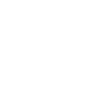

In [4]:
cell50 = cells[50]

# de
print(cell50[0])
cell50[1]

In [5]:
g = cell50[1]

In [6]:
catchments_path = r'../shared/HydroBASINS_homogenized.shp'

In [ ]:
# read catchments

fig = plt.figure()
axes = plt.axes()
axes.set_aspect('equal', 'datalim')

#bounds = (138.8119327121311, -37.679166666666646, 152.4875, -24.591666666666637)
#axes.set_xlim(bounds[0], bounds[2])
#axes.set_ylim(bounds[1], bounds[3])

with fiona.collection(catchments_path, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])
        pfaf_id = int(f['properties']['PFAF_ID'])
        
        # if pfaf_id >= 564000 and pfaf_id <= 564999:
        draw(geom, fill='#aaaaff', alpha=0.5)
        draw(geom.buffer(0.001), fill='#aaaaff', alpha=0.5)
            
draw(cell50[1], outline='#ffaaaa', lw=2.0)            

plt.show()  


4060044190


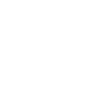

In [7]:
catchments = []
with fiona.collection(catchments_path, "r") as input:
    for f in input:
        geom = sl.geometry.shape(f['geometry'])
        pfaf_id = int(f['properties']['PFAF_ID'])
        id = int(f['properties']['HYBAS_ID'])
        
        # if pfaf_id >= 564000 and pfaf_id <= 564999:
        #     catchments.append((id, geom))
        catchments.append((id, geom))

print(catchments[0][0])
catchments[0][1]

* convert all catchments to shp files id_catchment.shp
* convert all grid cells to shp files id_cell.shp

* foreach grid cell:
    * find overlapping catchments
	* foreach overlapping raster
		* clip raster by its catchment:
	* merge all overlapping and clipped rasters

In [8]:
from shapely.geometry import mapping
from shapely.ops import cascaded_union
import fiona
import subprocess
import os
import glob

cleanup = True
# cleanup = False

def remove_file(path):
    if os.path.exists(path):
        os.remove(path)

def clip_catchment_by_cell(cell_geom, catchment_geom):
    return cell_geom.intersection(catchment_geom)

def write_shp(geom, shp_path, id):
    schema = { 'geometry': 'Polygon', 'properties': {'id': 'int'}, }

    with fiona.open(shp_path, 'w', 'ESRI Shapefile', schema) as c:
        c.write({'geometry': mapping(geom), 'properties': {'id': id}})

def compress_raster(in_path, out_path):
    cmd = 'gdal_translate -co COMPRESS=DEFLATE -co PREDICTOR=2 -co ZLEVEL=6 -of GTiff {0} {1}'.format(in_path, out_path)
    subprocess.check_call(cmd, shell=True)
    pass

def clip_raster(in_path, out_path, shp_path):
    cmd = u'gdalwarp -dstnodata -99999 -q -cutline {0} -crop_to_cutline -of GTiff {1} {2}'.format(shp_path, in_path, out_path)
    subprocess.check_call(cmd, shell=True)
    pass

def merge_rasters(in_paths, out_path):
    merge_cmd = r'gdal_merge.py'
    cmd = merge_cmd + u' -n -99999 -a_nodata -99999 -of GTiff -o {0} {1}'.format(out_path, in_paths)
    subprocess.check_call(cmd, shell=True)
    pass

def merge_shapefiles(in_paths, out_path):
    cmd = u'ogr2ogr -f "ESRI Shapefile" {0} {1}'.format(out_path, in_paths[0])
    subprocess.check_call(cmd, shell=True)

    for f in in_paths[1:]:
        cmd = u'ogr2ogr -f "ESRI Shapefile" -update -append {0} {1} -nln merge'.format(out_path, f)
        subprocess.check_call(cmd, shell=True)

def generate_tile_raster(cell, catchments, catchment_raster_format, cell_raster_format, temp_dir):
    # print('Merging sub-catchments raster for cell {0}: '.format(cell[0]))
    
    cell_id = cell[0]
    cell_geom = cell[1].buffer(0.001)
    
    out_catchment_rasters = []
    out_catchment_geometries = []
    for (idx, catchment) in enumerate(cell_catchments):
        catchment_id = catchment[0]
        catchment_geom = catchment[1].buffer(0.001)
        
        # clip catchment raster by the polygon from previous step
        in_catchment_rasters = glob.glob(catchment_raster_format.format(catchment_id))
        
        if len(in_catchment_rasters) == 0:
            print('Cannot find catchment file: ' + catchment_raster_format.format(catchment_id))
            text_file = open("missing.txt", "a")
            text_file.write(str(catchment_id) + '\n')
            text_file.close()
            continue
        in_catchment_raster = in_catchment_rasters[0]

        # write (catchment x cell) to Shapefile
        g = clip_catchment_by_cell(cell_geom, catchment_geom)
        
        if g.area < 1e-5:
            continue
        
        out_catchment_geometries.append(g)
        
        clip_shp = temp_dir + str(idx) + '.shp'
        write_shp(g, clip_shp, idx)
        
        # print(str(idx) + ' ' + in_catchment_raster)
        out_catchment_raster = temp_dir + str(idx) + '.tif'
        
        # print('Clipping ' + in_catchment_raster + ' ...')
        clip_raster(in_catchment_raster, out_catchment_raster, clip_shp)

        out_catchment_rasters.append(out_catchment_raster)

    if len(out_catchment_rasters) == 0:
        return
    
    # merge sub-catchment rasters clipped by intersection of (cell x catchment)
    merge_rasters(' '.join(out_catchment_rasters), temp_dir + 'tile.tif')
    
    # merge catchments
    merged = cascaded_union(out_catchment_geometries)
    write_shp(merged, temp_dir + 'merge.shp', 0)

    # clip raster
    tile_path = cell_raster_format.format('{0:05}'.format(cell_id))
    clip_raster(temp_dir + 'tile.tif', temp_dir + 'tile_clipped.tif', temp_dir + 'merge.shp')
    compress_raster(temp_dir + 'tile_clipped.tif', tile_path)
    
    # clean-up
    if cleanup:
        # clean-up
        if cleanup:
            for (idx, catchment) in enumerate(cell_catchments):
                remove_file(temp_dir + str(idx) + '.cpg')
                remove_file(temp_dir + str(idx) + '.dbf')
                remove_file(temp_dir + str(idx) + '.shp')
                remove_file(temp_dir + str(idx) + '.shx')

        remove_file(temp_dir + 'merge.cpg')
        remove_file(temp_dir + 'merge.dbf')
        remove_file(temp_dir + 'merge.shp')
        remove_file(temp_dir + 'merge.shx')

        remove_file(temp_dir + 'tile.tif')
        remove_file(temp_dir + 'tile_clipped.tif')
        
        for path in out_catchment_rasters:
            remove_file(path)

In [9]:
def get_overlapping_catchments(g):
    for catchment in catchments:
        id = catchment[0]
        geom = catchment[1]
        if geom.intersects(g):
            yield (id, geom)

In [ ]:
# Global HAND
idx = 0
for cell in cells[idx:]:
    cell_id = cell[0]
    cell_geom = cell[1]
    cell_catchments = list(get_overlapping_catchments(cell_geom))
    
    if len(cell_catchments) > 0:
        print('cell: {0}, id: {1}, catchment_count: {2}'.format(idx, cell_id, len(cell_catchments)))
        
    # generate_tile_raster(cell, cell_catchments, 
    #    '../output/continents/*/SRTM_30_*_{0}_hand.tif', 
    #    '../output/tiles/hand/HAND_100_cell_{0}.tif', 
    #    r'../temp/')

    # generate_tile_raster(cell, cell_catchments, 
    #    '../output/continents/*/SRTM_30_*_{0}_ldd.tif', 
    #    '../output/tiles/tiled_ldd/LDD_cell_{0}.tif', 
    #    r'../temp/')

    # generate_tile_raster(cell, cell_catchments, 
    #     '../output/continents/*/SRTM_30_*_{0}_dem_pits_diff.tif', 
    #     '../output/tiles/tiled_pits/PITS_DIFF_cell_{0}.tif', 
    #     r'../temp/')

    # generate_tile_raster(cell, cell_catchments, 
    #     '../output/continents/*/SRTM_30_*_{0}_fa.tif',
    #     '../output/tiles/tiled_fa/FA_cell_{0}.tif', 
    #     r'../temp/')

    # generate_tile_raster(cell, cell_catchments, 
    #      '../output/continents/*/SRTM_30_*_{0}_dist.tif',
    #      '../output/tiles/dand/DIST_cell_{0}.tif', 
    #      r'../temp/')
    
    generate_tile_raster(cell, cell_catchments, 
         '../output/continents_hand_extra/*/SRTM_30_*_{0}_1000_hand.tif',
         '../output/tiles/hand_1000/HAND_1000_{0}.tif', 
         r'../temp/')

    idx = idx + 1


cell: 28, id: 28, catchment_count: 7
cell: 30, id: 30, catchment_count: 1
cell: 31, id: 31, catchment_count: 11

In [ ]:
# compute unique missing catchment ids
f=open('missing.txt')
s = set([int(l) for l in f])
print(s)